In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt

In [3]:
## Parameters
CAL_INPUT_IMAGE_DIR = "camera_cal"
CAL_OUTPUT_FILE = "calibration_params.p"
TEST_IMAGE_DIR = "test_images"
S_THRESHOLD = (75, 255)
W_THRESHOLD = (225, 255)
B_THRESHOLD = (0, 35)
GRADIENT_X_THRESHOLD = (5, 100)
GRADIENT_Y_THRESHOLD = (0, 5000)
GRADIENT_MAG_THRESHOLD = (30, 100)
GRADIENT_DIR_THRESHOLD =(0.7, 1.3)
YM_PER_PIX = 30/720 # meters per pixel in y dimension
XM_PER_PIX = 3.7/700 # meters per pixel in x dimension
FONT = cv2.FONT_HERSHEY_SIMPLEX    

In [4]:
# Step 1: Calibrate camera, if not done before
class Utils:
    
    @staticmethod
    def calibrate_camera(image_dir, nx, ny, image_size):
        '''
        Compute and return camera calibration parameters
        '''
        
        if os.path.isfile(CAL_OUTPUT_FILE):
            print("Calibration has been done before, will skip!")
            cal_params = pickle.load( open( CAL_OUTPUT_FILE, "rb" ) )
            return cal_params
        else: 
            print("Needs calibration, proceeding...")
            objp = np.zeros((ny*nx, 3), np.float32)
            objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            objpoints = []
            imgpoints = []

            images = glob.glob(os.path.join(image_dir, '*.jpg'))
            for ids, fname in enumerate(images):
                img = cv2.imread(fname)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                if ret is True:
                    objpoints.append(objp)
                    imgpoints.append(corners)

            any_image = cv2.imread(images[0])
            img_size = (any_image.shape[1], any_image.shape[0])
            print("Image size is {}".format(img_size))
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            
            calibration_params = {}
            calibration_params["mtx"] = mtx
            calibration_params["dist"] = dist
            f = open (CAL_OUTPUT_FILE, "wb")
            pickle.dump(calibration_params, f)
            print("Camera calibration parameters written to {}".format(CAL_OUTPUT_FILE))
            return calibration_params

    @staticmethod
    def to_gray_scale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   
    @staticmethod
    def gradient_x_threshold(gray_image, min_max):
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobelx = np.uint8(255 * (abs_sobelx/(np.max(abs_sobelx))))
        binary = np.zeros_like(scaled_sobelx)
        binary[(scaled_sobelx >= min_max[0]) & (scaled_sobelx <= min_max[1])] = 1
        return binary
    
    @staticmethod
    def grad_y_threshold(gray_image, min_max):
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1)
        abs_sobely = np.absolute(sobely)
        scaled_sobely = np.uint8(255 * (abs_sobely/(np.max(abs_sobely))))
        binary = np.zeros_like(scaled_sobely)
        binary[(scaled_sobely >= min_max[0]) & (scaled_sobely <= min_max[1])] = 1
        return binary
    
    @staticmethod
    def grad_mag_threshold(gray_image, min_max):
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=9)
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=9)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        grad_mg = np.sqrt(abs_sobelx**2 + abs_sobely**2) 
        scaled_grad_mag = np.uint8(255 * (grad_mg/(np.max(grad_mg))))
        binary = np.zeros_like(scaled_grad_mag)
        binary[(scaled_grad_mag > min_max[0]) & (scaled_grad_mag <= min_max[1])] = 1
        return binary
    
    @staticmethod
    def color_threshold(image, min_max):
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        channel_s = hls[:,:,2]
        binary = np.zeros_like(channel_s)
        binary[(channel_s >= min_max[0]) & (channel_s <=min_max[1])] = 1
        return binary
    
    @staticmethod
    def white_threshold(image, min_max):
        B,G,R = image[:,:,0],  image[:,:,1],  image[:,:,2]
        binary = np.zeros_like(B)
        binary[(B >= min_max[0]) & (B <=min_max[1]) & ((R >=min_max[0]) & (R <=min_max[1])) & ((G >=min_max[0]) & (G <=min_max[1]))] = 1
        return binary
    
    @staticmethod
    def black_threshold(image, min_max):
        B,G,R = image[:,:,0],  image[:,:,1],  image[:,:,2]
        binary = np.zeros_like(B)
        binary[(B >= min_max[0]) & (B <=min_max[1]) & ((R >=min_max[0]) & (R <=min_max[1])) & ((G >=min_max[0]) & (G <=min_max[1]))] = 1
        return binary
    
    @staticmethod
    def grad_dir_threshold(gray_image, min_max):
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 15)
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 15)
        angle = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary =  np.zeros_like(angle)
        binary[(angle >= min_max[0]) & (angle <= min_max[1])] = 1
        return binary 

    @staticmethod                       
    def get_perspective_src_dst_points(image):
        src_vertices = np.float32([[600, 450],[700, 450],[1120, 720],[200, 720]])
        dst_vertices = np.float32([[320,0],[950,0],[950,720],[320,720]])
        return (src_vertices, dst_vertices)
                        
    @staticmethod                       
    def histogram(image):
        return np.sum(image[image.shape[0]//2:,:], axis=0)

    @staticmethod
    def apply_thresholds(image):
        color_threshold_img    = Utils.color_threshold(image, S_THRESHOLD)
        white_threshold_img    = Utils.white_threshold(image, W_THRESHOLD)
        black_threshold_img    = Utils.black_threshold(image, B_THRESHOLD)
        gray = Utils.to_gray_scale(image)
        gradx_binary = Utils.gradient_x_threshold(gray, GRADIENT_X_THRESHOLD)
        grady_binary = Utils.grad_y_threshold(gray, GRADIENT_Y_THRESHOLD)
        mag_binary   = Utils.grad_mag_threshold(gray, GRADIENT_MAG_THRESHOLD)
        dir_binary   = Utils.grad_dir_threshold(gray, GRADIENT_DIR_THRESHOLD)
        combined = np.zeros_like(gray)
        #combined[(color_threshold_img == 1) & ((gradx_binary == 1) | ((mag_binary == 1) | (dir_binary == 1)))] = 1
        combined[ (black_threshold_img == 0) & (color_threshold_img == 1) & (gradx_binary == 1) | (white_threshold_img == 1)] = 1
        return combined
  
    @staticmethod
    def init_lane_polynomials(warped_binary):
        # build histogram
        histogram = Utils.histogram(warped_binary)
        out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255

        midpoint = np.int(histogram.shape[0]/2)
        # initialize x-locations for left and right lane
        leftx_base = np.argmax(histogram[0:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        n_windows = 9
        window_height = np.int(warped_binary.shape[0]/n_windows)
        non_zero = warped_binary.nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])

        left_x_current = leftx_base
        right_x_current = rightx_base
        margin = 100
        minpix = 50
        
        left_lane_inds = []
        right_lane_inds = []
        
        y_max = warped_binary.shape[0]
        x_max = warped_binary.shape[1]
        for window in range(n_windows):
            win_y_high = y_max - window * window_height
            win_y_low  = win_y_high - window_height
            
            win_xleft_low  = left_x_current - margin
            win_xleft_high = left_x_current + margin
            win_xright_low  = right_x_current - margin
            win_xright_high = right_x_current + margin
            
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),  (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
           
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xleft_low) & (non_zero_x < win_xleft_high)).nonzero()[0]
            good_right_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xright_low) & (non_zero_x < win_xright_high)).nonzero()[0]

            #title = "window {} [{},{}]".format(window, len(good_left_inds), len(good_right_inds))
            #Utils.plot_single(out_img, title, (9,9))

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                left_x_current = np.int(np.mean(non_zero_x[good_left_inds]))
            if len(good_right_inds) > minpix:
                right_x_current = np.int(np.mean(non_zero_x[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = non_zero_x[left_lane_inds]
        lefty = non_zero_y[left_lane_inds] 
        rightx = non_zero_x[right_lane_inds]
        righty = non_zero_y[right_lane_inds] 

        # Fit a second order polynomial to each
        left_line = Line()
        right_line = Line()
        if (len(lefty) > 0):
            left_poly = np.polyfit(lefty, leftx, 2)
            left_line.set(leftx, left_poly, left_lane_inds, lefty, leftx)
            
        if (len(righty) > 0):
            right_poly = np.polyfit(righty, rightx, 2)
            right_line.set(rightx, right_poly, right_lane_inds, righty, rightx)
        return left_line, right_line

    @staticmethod                              
    def find_lane_polynomials(warped_binary, left_line, right_line):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        left_coefficients = left_line.current_fit
        right_coefficients = right_line.current_fit

        # Again, extract left and right line pixel positions
        margin = 100
        nonzero = warped_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
       
        # restrcited search area around the previous polynomials
        left_lane_inds = ((nonzerox > (left_coefficients[0]*(nonzeroy**2) + left_coefficients[1]*nonzeroy + left_coefficients[2] - margin)) & (nonzerox < (left_coefficients[0]*(nonzeroy**2) + left_coefficients[1]*nonzeroy + left_coefficients[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_coefficients[0]*(nonzeroy**2) + right_coefficients[1]*nonzeroy + right_coefficients[2] - margin)) & (nonzerox < (right_coefficients[0]*(nonzeroy**2) + right_coefficients[1]*nonzeroy + right_coefficients[2] + margin)))  

          
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        if len(lefty) > 0:
            left_fit = np.polyfit(lefty, leftx, 2)
            radius_left = Line.compute_radius(left_fit)
        
        if len(righty) > 0:
            right_fit = np.polyfit(righty, rightx, 2)
            radius_left = Line.compute_radius(right_fit)
            
        left_similar = Line.areSimilar(left_fit, left_line.current_fit) 
        right_similar = Line.areSimilar(right_fit, right_line.current_fit) 

        if left_similar and right_similar:
            left_line.set(leftx, left_fit, left_lane_inds, lefty, leftx)
            right_line.set(rightx, right_fit, right_lane_inds, righty, rightx)
            return left_line, right_line
        else:
            # do a sliding window search
            new_left, new_right = Utils.init_lane_polynomials(warped_binary)
            return  new_left, new_right 
  
    @staticmethod
    def plot(image, left_fit, right_fit):
        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    @staticmethod
    def plot_triplet(img1_with_title, img2_with_title, img3_with_title):
        if img1_with_title[2]:
            img1_with_title = (cv2.cvtColor(img1_with_title[0], cv2.COLOR_BGR2RGB), img1_with_title[1])
        if img2_with_title[2]:
            img2_with_title = (cv2.cvtColor(img2_with_title[0], cv2.COLOR_BGR2RGB), img2_with_title[1])
        if img3_with_title[2]:
            img3_with_title = (cv2.cvtColor(img3_with_title[0], cv2.COLOR_BGR2RGB), img2_with_title[1])
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 9))
        f.tight_layout()
        ax1.imshow(img1_with_title[0])
        ax1.set_title(img1_with_title[1], fontsize=10)
        ax2.imshow(img2_with_title[0])
        ax2.set_title(img2_with_title[1], fontsize=10)
        ax3.imshow(img3_with_title[0])
        ax3.set_title(img3_with_title[1], fontsize=10)     
 
    @staticmethod
    def plot_single_histogram(image, title):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
        ax1.imshow(image.squeeze())   
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        ax2.axis([0, image.shape[1], 0, 350])
        ax2.grid(True)
        ax2.xlim(0, 1280)
        ax2.ylim(720, 0)
        ax2.plot(histogram)
        
    @staticmethod
    def plot_single(image, title, toRGB = False, size=(3,3)):
        plt.figure(figsize = size)
        if toRGB:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image.squeeze())
        plt.title(title)
        
    @staticmethod
    def eval_polynomial(c, y):
        return c[0] * y**2 + c[1] * y + c[2]



In [5]:
class Line:
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #pixel positions
        self.pixel_positions = None
        #ral world radius
        self.radius_real_world = None
    
    def set(self, x_fit, coefficients, pixel_positions, y_pixels, x_pixels):
        self.detected = True
        self.recent_xfitted.append(x_fit)
        self.current_fit = coefficients
        self.pixel_positions = pixel_positions
        self.ally = y_pixels
        self.allx = x_pixels
        self.radius_of_curvature = Line.compute_radius(coefficients)
        fit_cr = np.polyfit(y_pixels*YM_PER_PIX, x_pixels*XM_PER_PIX, 2)
        self.radius_real_world = ((1 + (2*fit_cr[0]*720*YM_PER_PIX + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
                
    @staticmethod
    def areSimilar(polyA, polyB):
        radius_a = Line.compute_radius(polyA)
        radius_b = Line.compute_radius(polyB)
        if np.absolute(radius_a - radius_b) <  100:
            return True
        else:
            return False
    
    @staticmethod
    def compute_radius(coefficients):
        return ((1 + (2*coefficients[0]*720 + coefficients[1])**2)**1.5) / np.absolute(2*coefficients[0])
    

In [6]:
class Pipeline:
    
  
    def __init__(self):
        self.cal_mtx = None
        self.cal_dist = None
        self.pers_M = None
        self.target_width = None
        self.target_height = None
        self.calibration_done = False
        self.lanes_initialized = False
        self.nx = 9
        self.ny = 6
        self.left_line = None
        self.right_line = None
            
    def undistort(self, image):
        # calibrate camera if not done before
        if self.calibration_done is False:
            image_size = (image.shape[0], image.shape[1])
            cal_params = Utils.calibrate_camera(CAL_INPUT_IMAGE_DIR, self.nx, self.ny, image_size)
            self.cal_mtx = cal_params["mtx"]
            self.cal_dist = cal_params["dist"]
            self.calibration_done = True
        
        return cv2.undistort(image, self.cal_mtx, self.cal_dist, None, self.cal_mtx)      
    
    def warp_perspective(self, image):
        # evaluate perspective transformation matrix, if not done before
        if self.pers_M is None:
            src, dst = Utils.get_perspective_src_dst_points(image)
            self.pers_M = cv2.getPerspectiveTransform(src, dst)
            self.M_inv = cv2.getPerspectiveTransform(dst, src)
        
        img_size = (image.shape[1], image.shape[0])
        warped_binary = cv2.warpPerspective(image, self.pers_M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        return warped_binary
    
    def detect_lanes(self, warped_binary):
        # initialize left and right polynomials (for first image input)
        if self.lanes_initialized is False:
            l_line, r_line = Utils.init_lane_polynomials(warped_binary)
            self.left_line = l_line
            self.right_line = r_line
            if l_line.detected and r_line.detected:    
                self.lanes_initialized = True
        else:
            l_line, r_line = Utils.find_lane_polynomials(warped_binary, self.left_line, self.right_line)
            self.left_line = l_line
            self.right_line = r_line
        return self.left_line, self.right_line  
              
    def process(self, image):
        undistorted = self.undistort(image)
        binary_thresholded = Utils.apply_thresholds(undistorted)
        warped = self.warp_perspective(binary_thresholded)
        left_lane, right_lane = self.detect_lanes(warped)
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_lane.allx, left_lane.ally]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.allx, right_lane.ally])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, pipeline.M_inv, (warped.shape[1], warped.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
        # Write radius of curvature
        left_radius = np.int(left_lane.radius_real_world)
        right_radius = np.int(right_lane.radius_real_world)
        radius = min(left_radius, right_radius)
        text = "Radius of Curvature {} m".format(radius)
        cv2.putText(result,text,(10,50), FONT, 1,(255,255,255),2)
        
        # Compute distance from center
        vehicle_position = warped.shape[1]/2
        y_pos_bottom = warped.shape[0]
        left_lane_pos = Utils.eval_polynomial(left_lane.current_fit, y_pos_bottom)
        right_lane_pos = Utils.eval_polynomial(right_lane.current_fit, y_pos_bottom)
        lane_center = (left_lane_pos + right_lane_pos)/2
        distance_from_center =  round(((vehicle_position - lane_center) * XM_PER_PIX),2)
        text = "Distance from center {} m".format(distance_from_center)
        cv2.putText(result,text,(10,85), FONT, 1,(255,255,255),2)
        
        return result
    
    def get_lanes(self):
        return self.left_line, self.right_line

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
pipeline = Pipeline()
def process_image(image):
    return pipeline.process(image)

Populating the interactive namespace from numpy and matplotlib
Calibration has been done before, will skip!


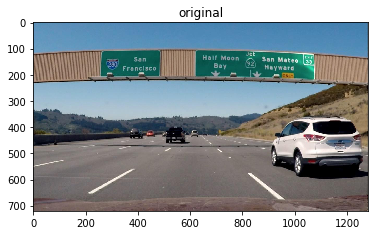

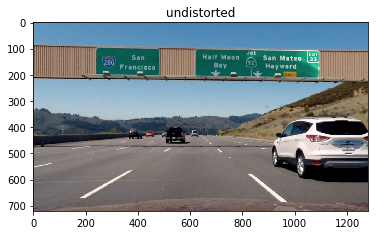

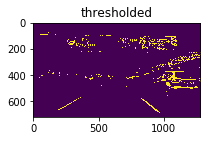

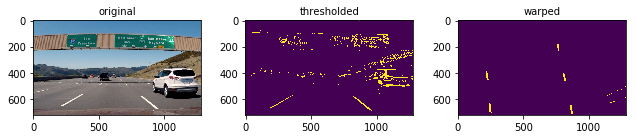

In [9]:
import os
import matplotlib.pyplot as plt
%pylab inline

test_images = glob.glob(os.path.join(TEST_IMAGE_DIR, 'quiz.png'))

warped_images = []
histograms = []
for test_image_path in test_images:
    test_image = cv2.imread(test_image_path)
    Utils.plot_single(test_image, "original", True, (6,6))
    undistorted = pipeline.undistort(test_image)
    Utils.plot_single(undistorted, "undistorted", True, (6,6))

    binary_thresholded = Utils.apply_thresholds(undistorted)
    Utils.plot_single(binary_thresholded, "thresholded")

    warped = pipeline.warp_perspective(binary_thresholded)
    warped_images.append(warped)

    Utils.plot_triplet((test_image, "original", True), (binary_thresholded, "thresholded", False), (warped, "warped", False))
    
plt.show()
plt.close()

Populating the interactive namespace from numpy and matplotlib


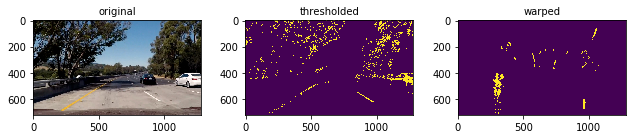

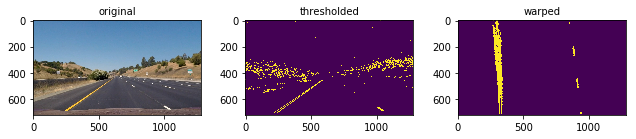

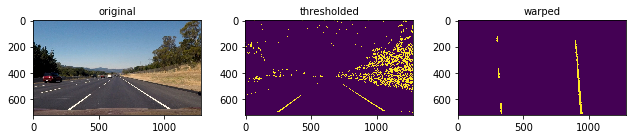

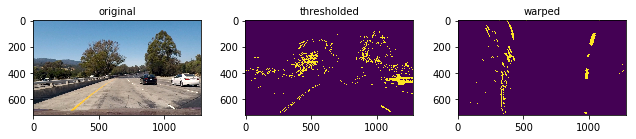

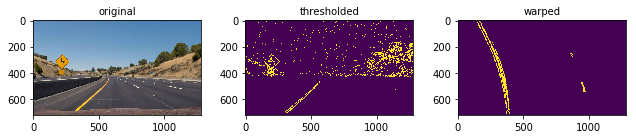

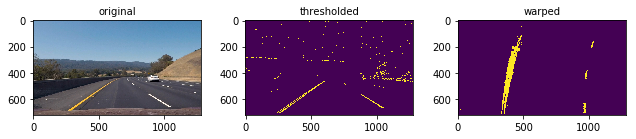

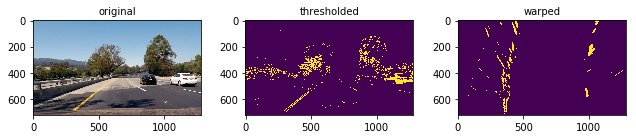

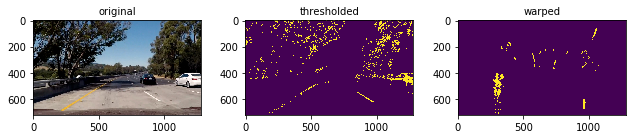

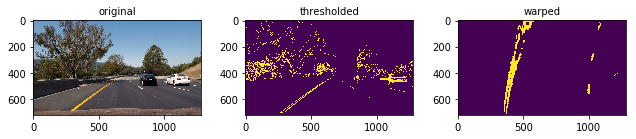

In [10]:
import os
import matplotlib.pyplot as plt
%pylab inline

test_images = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg'))

warped_images = []
histograms = []
for test_image_path in test_images:
    test_image = cv2.imread(test_image_path)
    undistorted = pipeline.undistort(test_image)
    binary_thresholded = Utils.apply_thresholds(undistorted)
    warped = pipeline.warp_perspective(binary_thresholded)
    warped_images.append(warped)
    Utils.plot_triplet((test_image, "original", True), (binary_thresholded, "thresholded", False), (warped, "warped", False))
    
plt.show()
plt.close()


In [11]:
#for warped in warped_images[0:1]:
 #   Utils.plot_single_histogram(warped, "warped")

Populating the interactive namespace from numpy and matplotlib


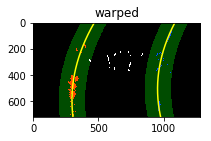

Radius Left Lane: 338.7434923004233 Right Lane: 319.196171983814


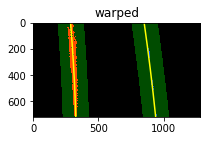

Radius Left Lane: 4520.913490492492 Right Lane: 6126.130358346886


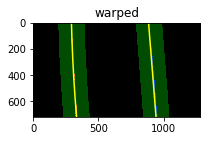

Radius Left Lane: 3871.971579674433 Right Lane: 70447.26286612132


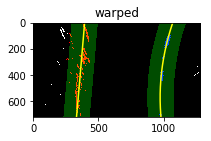

Radius Left Lane: 37031.04365846301 Right Lane: 558.7286157804083


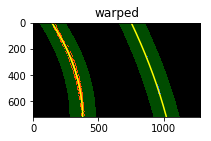

Radius Left Lane: 367.57218674012285 Right Lane: 1131.9079749622122


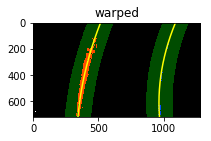

Radius Left Lane: 766.8720794516194 Right Lane: 487.2481323791799


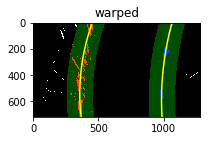

Radius Left Lane: 503.7510608771675 Right Lane: 713.0326674401222


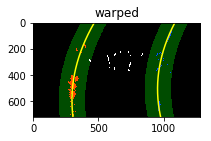

Radius Left Lane: 338.7434923004233 Right Lane: 319.196171983814


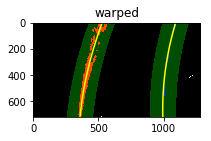

Radius Left Lane: 859.7649316963957 Right Lane: 734.5753073904772


In [12]:
pipeline.lanes_initialized = False
%pylab inline

def plot_lanes(warped, left_lane, right_lane):
       # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    Utils.plot_single(warped, "warped")
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    if left_lane.detected and right_lane.detected:
        left_poly_coefficients = left_lane.current_fit
        left_fitx = left_poly_coefficients[0]*ploty**2 + left_poly_coefficients[1]*ploty + left_poly_coefficients[2]
        left_lane_inds = left_lane.pixel_positions
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]

        right_poly_coefficients = right_lane.current_fit
        right_fitx = right_poly_coefficients[0]*ploty**2 + right_poly_coefficients[1]*ploty + right_poly_coefficients[2]
        right_lane_inds = right_lane.pixel_positions
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin=100
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.show()

for warped in warped_images:
    pipeline.detect_lanes(warped)
    left_lane, right_lane = pipeline.get_lanes()
    plot_lanes(warped, left_lane, right_lane)
    print("Radius Left Lane: {} Right Lane: {}".format(left_lane.radius_real_world, right_lane.radius_real_world))
    

Populating the interactive namespace from numpy and matplotlib
test_images/color-shadow-example.jpg


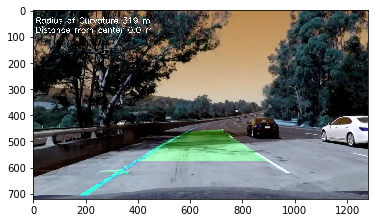

test_images/straight_lines1.jpg


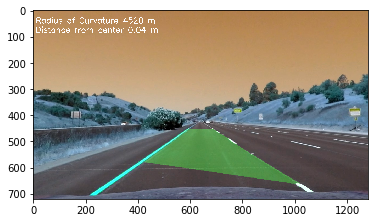

test_images/straight_lines2.jpg


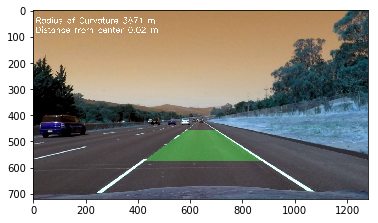

test_images/test1.jpg


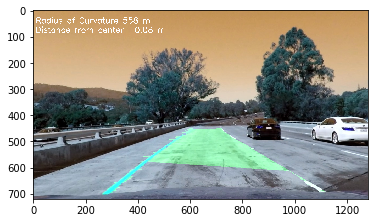

test_images/test2.jpg


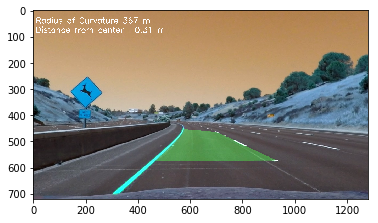

test_images/test3.jpg


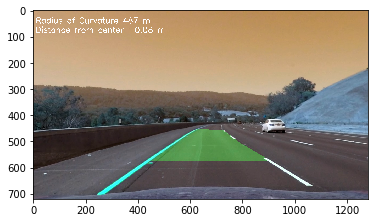

test_images/test4.jpg


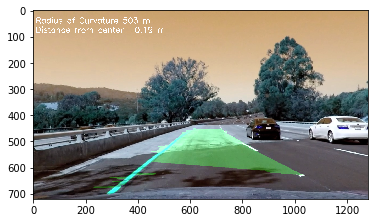

test_images/test5.jpg


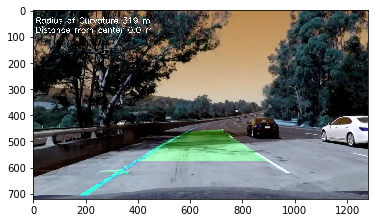

test_images/test6.jpg


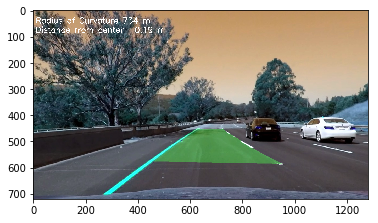

In [13]:
%pylab inline
test_images = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg'))

warped_images = []
histograms = []
for test_image_path in test_images:
    image = cv2.imread(test_image_path)
    result = pipeline.process(image)
    print(test_image_path)
    #result_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(result)
    plt.show()

plt.close()

In [ ]:
%pylab inline
output = 'project_output_colour_with_info.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline.process) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)